In [1]:
from src.ALMApy import get_k2_vs_radius
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from scipy.optimize import curve_fit


plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Serif"
})

Here we asses how the $k_2$ love number changes with differing sizes of the atmosphere. We use a solid (rocky) homogeneous core with an atmosphere of varying size. The fiducial parameters are:
- The core radius is equal to the radius of Neptune, $R_\mathrm{Nep}=24\times 10^6\textrm{ m}$.
- The core density is equal to the density of Neptune, $\rho_\mathrm{Nep}=1642\textrm{ kg m}^{-3}$.
- The core rigidity is taken from ALMA3's `simple-Earth` model, which is $10^11$
- The core viscosity is taken from ALMA3's `simple-Earth` model, which is $10^21$
- The atmosphere starts at the outer radius of the core, and extends to varying radii, up to the radius of Jupiter $R_\mathrm{Jup}=69.6\times 10^6\textrm{ m}$
- The atmosphere has a density equal to the density of the atmosphere at the surface of the earth, $\rho_\mathrm{air}=1.293\textrm{kg m}^{-3}$
- The atmosphere's viscosity is equal to the viscosity of air, $\nu=5\times 10^{-5}$
- The atmosphere's rigiditiy is negligible

In [2]:
G = 6.67e-11

# Dimensions
R_jupiter = 69.9e6
m_neptune = 1.024e26
R_neptune = 24.6e6
rho_neptune = m_neptune/(4*np.pi/3*R_neptune**3)

# Material properties
rho_air = 1.293
rigidity_air = 1e-7
viscosity_air = 3e-5
rigidity_earth = 1e11
viscosity_earth = 1e21


In [3]:
def get_k2_core(R_core, mu_core, rho_core):
    M_core = 4*np.pi/3*R_core**3*rho_core
    g_core = G*M_core/R_core**2
    return 3/(2*(1+19*mu_core/(2*g_core*rho_core*R_core)))

### Varying core radii

In [4]:
no_atm_radii = 100
log_max_atm_radius = 1 #maximum radius = 10**log_max_atm_radius * R_jupiter

no_core_radii = 10
min_core_radius = 0.5*R_neptune
max_core_radius = 5*R_neptune
core_radii = np.linspace(min_core_radius, max_core_radius, no_core_radii)

data = []

rerun_sim = False
if rerun_sim:
    for i,core_radius in enumerate(core_radii):
        atmosphere_radii = (np.logspace(-3,log_max_atm_radius,no_atm_radii)-10**-3)*R_jupiter+core_radius
        k2 = get_k2_vs_radius(core_radius, atmosphere_radii, [rho_air, rho_neptune], [rigidity_air, rigidity_earth], [viscosity_air, viscosity_earth])
        data.append({"core_radius": core_radius,
                     "radius": atmosphere_radii,
                     "k2": k2,})
        print(f"{(i+1)/len(core_radii)*100:.0f}% done")
    np.save("k2_fitting_data.npy", data)
else:
    data = np.load("k2_fitting_data.npy", allow_pickle=True)

### Giant atmosphere range

In [5]:
log_max_atm_radius = 3
atm_radii = (np.logspace(-3,log_max_atm_radius,no_atm_radii)-10**-3)*R_jupiter+min_core_radius
k2 = get_k2_vs_radius(min_core_radius, atm_radii, [rho_air, rho_neptune], [rigidity_air, rigidity_earth], [viscosity_air, viscosity_earth])
giant_atmosphere = {"core_radius": min_core_radius,
                    "radius": atm_radii,
                    "k2": k2}

# Fitting

In [6]:
def rho(x, rho_core, rho_atm):
    return (rho_core+rho_atm*(x**3-1))/x**3

def g(x, R_core, rho_core, rho_atm):
    return 4*np.pi/3*G*R_core*(rho_core+rho_atm*(x**3-1))/x**2

def mu(x, mu_core, a0,a1,a2,a3,a4,a5,a6):
    return mu_core*(a0+a1*x+a2*x**2+a3*x**3+a4*x**4+a5*x**5+a6*x**6)#2*mu_core/(1+x**n)

def k2_core(R_core, rho_core, mu_core):
    M_core = 4*np.pi/3*R_core**3*rho_core
    g_core = G*M_core/R_core**2
    return 3/(2*(1+19*mu_core/(2*g_core*rho_core*R_core)))

def k2_func(x, R_core, rho_core, rho_atm, mu_core,a0,a1,a2,a3,a4,a5,a6):
    return 3/(2*(1+19*mu(x,mu_core,a0,a1,a2,a3,a4,a5,a6)/(2*g(x,R_core,rho_core,rho_atm)*rho(x, rho_core,rho_atm)*x*R_core)))

def mu(x,mu_core):
    return mu_core*x**0.4

def k2_func(x, R_core, rho_core, rho_atm, mu_core):
    return 3/(2*(1+19*mu(x))/(2*g(x,R_core,rho_core,rho_atm)*rho(x, rho_core,rho_atm)*x*R_core))

In [7]:
print(f"rho core={rho_neptune}")
print(f"rho atm = {rho_air}")
print(f"mu_core = {rigidity_earth:.1e}")
print(f"R_core = {R_neptune:.1e}")


rho core=1642.124293334446
rho atm = 1.293
mu_core = 1.0e+11
R_core = 2.5e+07


### Fitting softly transitioning linear functions

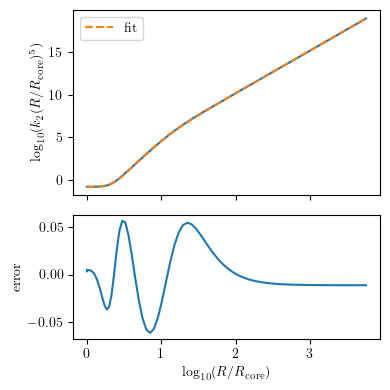

In [8]:
R_atm = giant_atmosphere["radius"]
k2 = giant_atmosphere["k2"]

x = np.log10(R_atm/min_core_radius)
y = np.log10(k2*(R_atm/min_core_radius)**5)

def g(x,x0,h):
    return np.log(1+np.exp((x-x0)*h))/h

def f(x,x0,x1,a,h0,h1):
    b=5
    return a*g(x,x0,h0) + (b-a)*g(x-x0,x1-x0,h1)+x0*a-x1*b

x0 = 0.4
x1 = 0.8
h = 10
a = 10
b = 5

popt,pcov = curve_fit(f, x, y, p0=[x0,x1,a,h,h])
x0, x1, a, h0, h1 = popt

fig, (ax,err_ax) = plt.subplots(nrows=2,sharex=True, figsize=(4,4), gridspec_kw={'height_ratios': [1.5, 1]})
ax.plot(x,y)
ax.plot(x,f(x,*popt), linestyle="--", label="fit")
err_ax.plot(x, y-f(x,*popt))

"""
x_int = np.linspace(x[0],x0,100)
ax.plot(x_int,x_int*0+np.log10(k2_core(rigidity_earth, rho_neptune, min_core_radius)), label="$k_2=k_{2,\\mathrm{core}}$")

x_int = np.linspace(x1,x[-1],100)
ax.plot(x_int,5*x_int, label="$k_2=3/2$")

x_int = np.linspace(x0,x1,100)
ax.plot(x_int,a*(x_int-x0)-x1*b+x0*a)

err_ax.set_xlabel("$x$")
ax.set_ylabel("$y$")
err_ax.set_ylabel("error")
"""

err_ax.set_xlabel("$\\log_{10}(R/R_\\mathrm{core})$")
ax.set_ylabel("$\\log_{10}(k_2(R/R_\\mathrm{core})^5)$")
err_ax.set_ylabel("error")

ax.legend()
fig.tight_layout()
plt.show()

### Fitting with three linear functions
Below we fit with all parameters free, so we have
$$
f(x)=
\begin{cases}
y_0, \quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad x<x_0\\
y_0+a(x-x_0),\quad\quad\quad\quad\quad\quad\quad x_0<x<x_1\\
y_0+a(x_1-x_0)+b(x-x_1),\quad x>x_1
\end{cases}
$$

x0 = 0.30
x1 = 1.23
a = 7.55
b = 5.03
y0 = -0.77
MSD = 1.76e-03


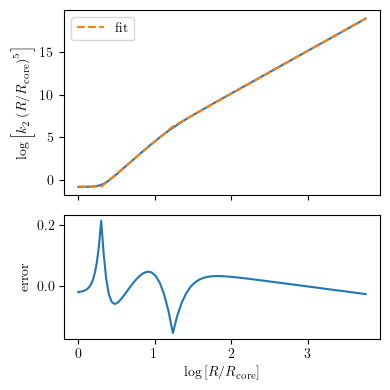

In [9]:
y0 = np.log10(k2_core(rigidity_earth, rho_neptune, min_core_radius))

def f(x,x0,x1,a,b,y0):
    y = y0 + a*(x1-x0) + b*(x-x1)
    y[x<x1] = y0 + a*(x[x<x1]-x0)
    y[x<x0] = y0
    return y

# Fit
popt,pcov = curve_fit(f, x, y, p0=[0.3,0.8,10,5,-0.5])

# Print results
variables = ["x0","x1","a","b","y0"]
for i in range(len(variables)):
    print(f"{variables[i]} = {popt[i]:.2f}")
print(f"MSD = {np.sum((y-f(x,*popt))**2)/len(x):.2e}")

# Plot results
fig, (ax,err_ax) = plt.subplots(nrows=2,sharex=True, figsize=(4,4), gridspec_kw={'height_ratios': [1.5,1]})
ax.plot(x,y)
ax.plot(x,f(x,*popt), linestyle="--", label="fit")
err_ax.plot(x, y-f(x,*popt))
err_ax.set_xlabel("$\\log{\\left[R/R_\\mathrm{core}\\right]}$")
ax.set_ylabel("$\\log{\\left[k_2\\left(R/R_\\mathrm{core}\\right)^5\\right]}$")
err_ax.set_ylabel("error")
ax.legend()
fig.tight_layout()
fig.savefig("linear_fit.png",dpi=300)
plt.show()

Below, we require that $y_0$ is equal to $\log_{10}\left(k_{2,\mathrm{core}}\right)$, since this is where the atmosphere is not there, and we have a simple analytical equation for the core's Love number.

Also, for large radii the atmosphere is dominant, so we effectively have a uniform planet with zero rigidity, which has $k_2=3/2$ (see Tremaine page 405), therefore
$$
y_0+a(x_1-x_0)+b(x-x_1)=\log_{10}{\left[k_2 \left(\frac{R}{R_\mathrm{core}}\right)^5\right]}
$$
which, using the definition of $x$ above, becomes
$$
y_0+a(x_1-x_0)+b(x-x_1)=\log_{10}{k_2} +5x
$$
this is solved by
$$
b=5
$$
and
$$
a = \frac{\log_{10}{k_2}+bx_1-y_0}{x_1-x_0}
$$
with $k_2=3/2$.

With these constraints, we can just fit for $x_0$ and $x_1$ (which are also optimized for the slope inbetween being suitable).

8.000000000013472
8.000000071539045
7.999999928487901
7.704753327718255
7.7047533898246785
7.704753265611833
7.61836250438436
7.618362563832945
7.618362444935777
7.544279475635152
7.5442795328399805
7.5442794184303255
7.542498442937568
7.5424985000888585
7.54249838578628
7.542497283896419
x0 = 0.43
x1 = 1.27
7.542497283896419
MSD = 3.50e-01
7.542497283896419
7.542497283896419


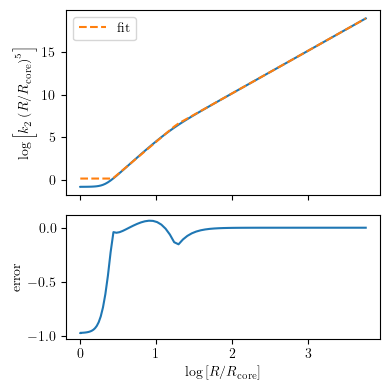

In [10]:
y0 = np.log10(k2_core(rigidity_earth, rho_neptune, min_core_radius))
b = 5

def f(x,x0,x1):
    a = (np.log10(3/2)+b*x1-y0)/(x1-x0)
    print(a)
    y = y0 + a*(x1-x0) + b*(x-x1)
    y[x<x1] = y0 + a*(x[x<x1]-x0)
    y[x<x0] = y0
    return y

popt,pcov = curve_fit(f, x, y, p0=[0.3,0.8])

# print results
variables = ["x0","x1"]
for i in range(len(variables)):
    print(f"{variables[i]} = {popt[i]:.2f}")
print(f"MSD = {np.sum((y-f(x,*popt))**2)/len(x):.2e}")

# Plot fit
fig, (ax,err_ax) = plt.subplots(nrows=2,sharex=True, figsize=(4,4), gridspec_kw={'height_ratios': [1.5,1]})
ax.plot(x,y)
ax.plot(x,f(x,*popt), linestyle="--", label="fit")
err_ax.plot(x, y-f(x,*popt))
err_ax.set_xlabel("$\\log{\\left[R/R_\\mathrm{core}\\right]}$")
ax.set_ylabel("$\\log{\\left[k_2\\left(R/R_\\mathrm{core}\\right)^5\\right]}$")
err_ax.set_ylabel("error")
ax.legend()
fig.tight_layout()
plt.show()

using
$$
x_0 = \frac{y_0+(a-b)x_1-\log_{10}{k_2}}{a}
$$

a = 7.54
x1 = 1.27
MSD = 3.50e-01


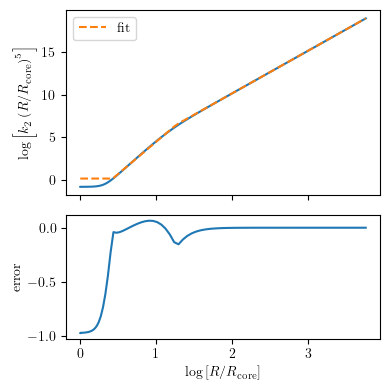

In [11]:
y0 = np.log10(k2_core(rigidity_earth, rho_neptune, min_core_radius))
b = 5

def f(x,a,x1):
    x0 = (y0+(a-b)*x1-np.log10(3/2))/a
    y = y0 + a*(x1-x0) + b*(x-x1)
    y[x<x1] = y0 + a*(x[x<x1]-x0)
    y[x<x0] = y0
    return y

popt,pcov = curve_fit(f, x, y, p0=[7.5,0.8])

# print results
variables = ["a","x1"]
for i in range(len(variables)):
    print(f"{variables[i]} = {popt[i]:.2f}")
print(f"MSD = {np.sum((y-f(x,*popt))**2)/len(x):.2e}")

# Plot fit
fig, (ax,err_ax) = plt.subplots(nrows=2,sharex=True, figsize=(4,4), gridspec_kw={'height_ratios': [1.5,1]})
ax.plot(x,y)
ax.plot(x,f(x,*popt), linestyle="--", label="fit")
err_ax.plot(x, y-f(x,*popt))
err_ax.set_xlabel("$\\log{\\left[R/R_\\mathrm{core}\\right]}$")
ax.set_ylabel("$\\log{\\left[k_2\\left(R/R_\\mathrm{core}\\right)^5\\right]}$")
err_ax.set_ylabel("error")
ax.legend()
fig.tight_layout()
plt.show()

### Concatenating all data for single fit

In [12]:
x_concat = np.array([])
y_concat = np.array([])
y0_concat = np.array([])
for i in range(no_core_radii):
    R_core = data[i]["core_radius"]
    R_atm = data[i]["radius"]
    k2 = data[i]["k2"]
    
    xi = np.log10(R_atm/R_core)
    x_concat = np.concatenate((x_concat,xi))

    yi = np.log10(k2*(R_atm/R_core)**5)
    y_concat = np.concatenate((y_concat,yi))

    y0i = np.log10(np.repeat(k2_core(rigidity_earth, rho_neptune, R_core), len(R_atm)))
    y0_concat = np.concatenate((y0_concat,y0i))


a = 7.54
x1 = 1.27
MSD = 3.50e-01


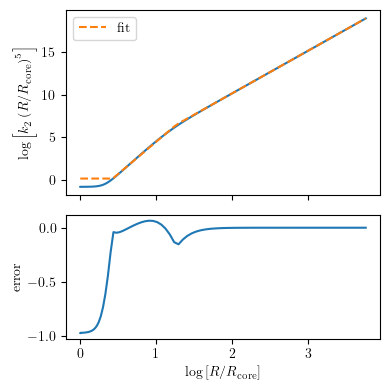

In [13]:
def f(x_concat,x0,x1):
    x0_concat = (y0_concat+(a-b)*x1-np.log10(3/2))/a
    y = y0_concat + a*(x1-x0_concat) + b*(x_concat-x1)
    y[x_concat<x1] = y0_concat[x_concat<x1] + a*(x_concat[x_concat<x1]-x0_concat[x_concat<x1])
    y[x_concat<x0] = y0_concat[x_concat<x0]
    return y

y0 = np.log10(k2_core(rigidity_earth, rho_neptune, min_core_radius))
b = 5

def f(x,a,x1):
    x0 = (y0+(a-b)*x1-np.log10(3/2))/a
    y = y0 + a*(x1-x0) + b*(x-x1)
    y[x<x1] = y0 + a*(x[x<x1]-x0)
    y[x<x0] = y0
    return y

popt,pcov = curve_fit(f, x, y, p0=[7.5,0.8])

# print results
variables = ["a","x1"]
for i in range(len(variables)):
    print(f"{variables[i]} = {popt[i]:.2f}")
print(f"MSD = {np.sum((y-f(x,*popt))**2)/len(x):.2e}")

# Plot fit
fig, (ax,err_ax) = plt.subplots(nrows=2,sharex=True, figsize=(4,4), gridspec_kw={'height_ratios': [1.5,1]})
ax.plot(x,y)
ax.plot(x,f(x,*popt), linestyle="--", label="fit")
err_ax.plot(x, y-f(x,*popt))
err_ax.set_xlabel("$\\log{\\left[R/R_\\mathrm{core}\\right]}$")
ax.set_ylabel("$\\log{\\left[k_2\\left(R/R_\\mathrm{core}\\right)^5\\right]}$")
err_ax.set_ylabel("error")
ax.legend()
fig.tight_layout()
plt.show()

NameError: name 'cmap' is not defined

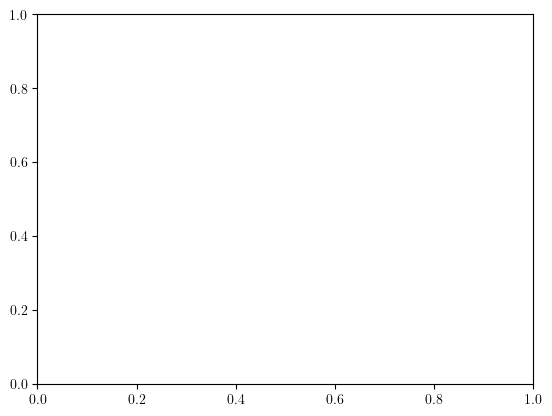

In [14]:
def f(x,a,x1,y0,b=5):
    x0 = (y0+(a-b)*x1-np.log10(3/2))/a
    y = y0 + a*(x1-x0) + b*(x-x1)
    y[x<x1] = y0 + a*(x[x<x1]-x0)
    y[x<x0] = y0
    return y

x_interp = np.linspace(0,1.75,100)


for i in range(len(data)):
    fig, ax = plt.subplots()
    R_core = data[i]["core_radius"]
    R_atm = data[i]["radius"]
    k2 = data[i]["k2"]
    y0 = np.log10(k2_core(rigidity_earth,rho_neptune,R_core))
    ax.plot(np.log10(R_atm/R_core), np.log10(k2*(R_atm/R_core)**5), color=cmap(norm(R_core/R_neptune)))
    ax.plot(x_interp, f(x_interp, 7.45, 1.28, y0))


    ax.set_xlabel("$\\log{\\left[R/R_\\mathrm{core}\\right]}$")
    ax.set_ylabel("$\\log{\\left[k_2\\left(R/R_\\mathrm{core}\\right)^5\\right]}$")

In [ ]:
print(10**1.28)
print(((10**1.28)**3-1)*rho_air/rho_neptune)

19.054607179632473
5.446653149391194


1000


TypeError: f() missing 1 required positional argument: 'y0'

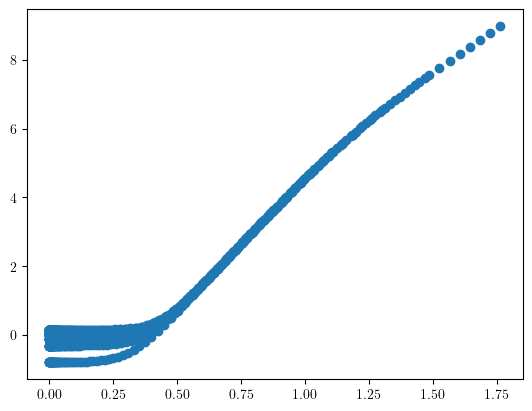

In [ ]:
plt.figure()
plt.scatter(x_concat, y_concat)
x_interp = np.repeat(np.linspace(0,2,100),len(core_radii))
print(len(x_interp))
print(len(f(x_interp,7.45,1.28)))
print(len(y0_concat))
plt.scatter(x_interp, f(x_interp,0.29,1.28), color="red", label="fit")

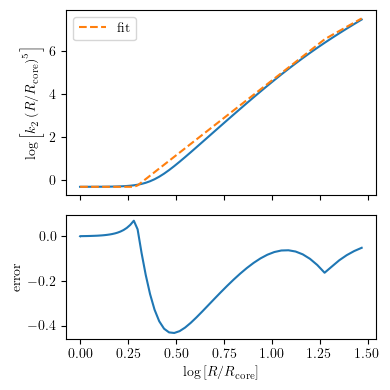

In [ ]:
idx = 1

R_atm = np.array([d["radius"] for d in data[idx]])
k2 = np.array([d["k2"] for d in data[idx]])

x = np.log10(R_atm/core_radii[idx])
y = np.log10(k2*(R_atm/core_radii[idx])**5)

y0 = np.log10(k2_core(rigidity_earth, rho_neptune, core_radii[idx]))


# Plot fit
fig, (ax,err_ax) = plt.subplots(nrows=2,sharex=True, figsize=(4,4), gridspec_kw={'height_ratios': [1.5,1]})
ax.plot(x,y)
ax.plot(x,f(x,*popt), linestyle="--", label="fit")
err_ax.plot(x, y-f(x,*popt))
err_ax.set_xlabel("$\\log{\\left[R/R_\\mathrm{core}\\right]}$")
ax.set_ylabel("$\\log{\\left[k_2\\left(R/R_\\mathrm{core}\\right)^5\\right]}$")
err_ax.set_ylabel("error")
ax.legend()
fig.tight_layout()
plt.show()